<a href="https://colab.research.google.com/github/RishiJain848/Optimisation/blob/master/Rishi_Jain_OHM_Term_Project_18IM10023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Need to mount drive if taking csv from there

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statistics
import random
import itertools
from heapq import nlargest

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

#**DATA LOADING**


In [ ]:
"""you need to incorporate this CSV file as per your convenience using drive or maybe local storage. Please find CSV attached in the submitted folder"""

D = pd.read_csv("/content/drive/MyDrive/6th sem/OHM.csv")       #importing our dataset as dataframe
D.drop(['Unnamed: 0'],axis=1,inplace=True)
D.head()

,drill,hole,RUL,tf1,tf2,tf3,tf4,tf5,tf6,tf7,tf8,tf9,tf10,tf11,tf12,tf13,tf14,tf15,tf16,tf17,tf18,tf19,tf20,tf21,tf22,tf23,tf24,tf25,tf26,tf27,tf28,tf29,tf30,tf31,tf32,tf33,tf34,tf35,tf36,tf37,...,to577,to578,to579,to580,to581,to582,to583,to584,to585,to586,to587,to588,to589,to590,to591,to592,to593,to594,to595,to596,to597,to598,to599,to600,to601,to602,to603,to604,to605,to606,to607,to608,to609,to610,to611,to612,to613,to614,to615,to616
0,1,1,20,0,0,4.0348,17.8646,24.2476,32.7582,35.9497,42.3327,45.5242,55.0986,65.7370,79.5668,92.3327,107.6862,122.2633,136.8404,152.5388,167.1159,176.0865,186.1783,192.9062,194.0275,196.2701,199.6445,196.2701,196.2701,198.5128,203.0466,200.7785,200.7785,206.4487,212.1189,217.7891,229.1294,234.7996,235.9336,246.1399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,19,0,0,5.0986,31.6944,54.0348,65.7370,75.3114,90.2051,98.7157,122.2633,143.5683,167.1159,185.0570,199.6445,212.1189,220.0571,224.5933,225.7273,229.1294,234.7996,234.7996,232.5315,230.2634,226.8613,223.4592,221.1912,215.5210,210.9849,212.1189,220.0571,225.7273,227.9954,232.5315,235.9336,240.4698,246.1399,250.6761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,18,0,0,23.1837,48.7157,62.5455,73.1838,90.2051,99.8370,126.7486,148.0536,168.2373,183.9357,199.6445,213.2529,221.1912,227.9954,232.5315,237.0677,238.2017,235.9336,232.5315,229.1294,223.4592,218.9231,215.5210,209.8508,212.1189,215.5210,216.6550,220.0571,224.5933,232.5315,239.3357,247.2740,250.6761,257.4803,266.5525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,17,0,0,10.4178,32.7582,52.9710,56.1625,60.4178,65.7370,71.0561,77.4391,84.8859,95.5242,105.4436,120.0207,136.8404,151.4175,164.8733,182.8144,190.6636,201.9126,208.7168,217.7891,224.5933,221.1912,220.0571,221.1912,217.7891,223.4592,221.1912,216.6550,214.3870,221.1912,226.8613,235.9336,239.3357,243.8719,254.0782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,16,0,0,5.0986,27.4391,45.5242,54.0348,59.3540,67.8646,74.2476,77.4391,80.6306,89.1412,98.7157,115.5354,131.2339,148.0536,165.9946,178.3291,190.6636,200.7785,212.1189,215.5210,216.6550,221.1912,220.0571,221.1912,218.9231,221.1912,218.9231,220.0571,223.4592,229.1294,233.6655,239.3357,240.4698,247.2740,250.6761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#defining dictionaries for storing data drill wise so for ease in split train-test split as per wish

X = {}
y = {}
for i in pd.unique(D['drill']):  
    X[i] = D[D['drill']==i].drop(["RUL","drill"],axis=1)
    y[i] = D[D['drill']==i]["RUL"]

train_drills = [1,3,4,6,7,8,10,11,12,14]    #data for these drills taken for training
test_drills = [5,2,9,13]                    #data for these drills taken for test

X_train = X[1]

for i in train_drills[1:]:
    X_train = X_train.append(X[i])

X_test = X[5]
for i in test_drills[1:]:
    X_test = X_test.append(X[i])

y_train = y[1]

for i in train_drills[1:]:
    y_train = y_train.append(y[i])

y_test = y[5]
for i in test_drills[1:]:
    y_test = y_test.append(y[i])



X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [ ]:
print("One data point respresents features for hole i for drill j, say d1h1")
print("number of data points for training",len(X_train))
print("number of data points for test",len(X_test))

One data point respresents features for hole i for drill j, say d1h1
number of data points for training 227
number of data points for test 107


#**DEFINING FUNCTIONS OF GENETIC ALGO**

In [ ]:
def initialize_population(population_size):
  
  no_neuron_choices = [8,16,32,64,128,256,512]      #initial choice of number of neurons for any layer

  population = []
  for i in range(population_size):
    temp = []
    temp.append(random.choice(no_neuron_choices))   #no of neurons in L1
    temp.append(random.choice(no_neuron_choices))   #no of neurons in L2
    temp.append(random.randint(100,500))            #Max Its
    temp.append(random.uniform(0.0001,0.001))       #LR

    population.append(temp)

  return population

In [ ]:
def fitness(p1):                       #fitness of an individual

  params = {}
  params["NL1"] = p1[0]
  params["NL2"] = p1[1]
  params["Max_its"] = p1[2]
  params["LR"] = p1[3]

  y_hat,model = model_fit(params)                   #we going to fit NN model with following params and pre-defined data

  fit = np.sqrt(mean_squared_error(y_hat,y_test))   #this is our RMSE over test set, our func to minimize  
  
  """                                               #this part can be called to define fitness in order to minimize Median RMSE of last 5 holes for test set drills
  RMSE = []
  for d in test_drills:
    error = []
    for i in y[d].keys():
      if y[d][i] <= 5:
        error.append(model.predict([np.array(X[d].loc[i])])-y[d][i])
    
    RMSE.append(np.sqrt(np.mean(np.power(error,2))))

  fit = statistics.median(RMSE)
  """

  fit = 10000000/(fit+0.1)                         #defining fitness func(to be maximized), to minimize RMSE

  return fit

In [ ]:
def selection(population, population_size):         #We just select top(say 10 if population size=10) individuals from population based on their fitness, just to fill up population_size

  fits = {}

  for i in range(len(population)):
    fits[i] = fitness(population[i])

  temp = nlargest(population_size, fits, key = fits.get)


  
  pop_next = []

  for i in temp:
    pop_next.append(population[i])

  return pop_next,population[temp[0]],fits[temp[0]]

In [ ]:
def crossover(p1,p2):
                                        #even when a pair goes for crossover checking Pc, here further we take some probabilty to change each variable of the chromosome
  c1 = p1
  c2 = p2 
                                        #Now i have defined these changing functions as per my will and understanding
  p = 0.6
                                        #for L1
  if random.random() < p:               #if random < 0.6, we crossover this variable, else it goes to children unchanged, same as their parent
    c1[0] = int((p1[0]+p2[0])/2)        #number of neurons L1 for child_1 goes as avg of parents
    c2[0] = max(p1[0],p2[0])            #number of neurons L1 for child_1 goes as max of parents

  if random.random() < p:               #for L2
    c1[1] = int((p1[1]+p2[1])/2)        #Similar as for L1 just above
    c2[1] = max(p1[1],p2[1])

  if random.random() < p:               #for max iterations
    c1[2] = max(p1[2],p2[2])            #Here I am passing max of both parents(maybe more number of iterations may help better results as i have choosen LR as very small values)
    c2[2] = max(p1[2],p2[2])

  if random.random() < p:               #for LR
    c1[3] = min(p1[3],p2[3])            #Here I am passing min of both parents(so as to exploit areas better)
    c2[3] = min(p1[3],p2[3])

  return c1,c2

In [ ]:
def mutation(p1):
                                        #Just like we did above in Crossover, even when a chromosome goes for mutation checking Pm, here further we take some probabilty to change each variable of the chromosome
  p = 0.8                               #also we need to keep bounds to the varibales as you may see, on every variable we are checking some bounds

  """for every variable now, we mutate it, either increment or decrement with equal probablity""" 

  if random.random() < p and int(p1[0]/2) >0 and int(p1[0]/2) <= 1024 :         #first check if these variable will mutate with probability p, then check bounds, then if generated_random_no < 0.5
    if random.random() < 0.5 :                                                  
      p1[0] = int(p1[0]/2)                                                      #we cut it half(decrement) otherwise 
    else:                                                                       
      p1[0] = int(p1[0]*2)                                                      #we double it(increment)

  if random.random() < p and int(p1[1]/2) >0 and int(p1[1]/2) <= 1024 :         #Similarily for all other variables
    if random.random() < 0.5 :
      p1[1] = int(p1[1]/2)
    else:
      p1[1] = int(p1[1]*2)

  if random.random() < p and p1[2]+50 <= 500 and p1[2]-50 >= 100:
    if random.random() < 0.5 :
      p1[2] = int(p1[2]+50)
    else:
      p1[2] = int(p1[2]-50)

  if random.random() < p and p1[3]/2 >= 0.0001 and p1[3]*2 <= 0.001:
    if random.random() < 0.5 :
      p1[3] = (p1[3]/2)
    else:
      p1[3] = (p1[3]*2)



  return p1

In [ ]:
def extract_params(population_i):

  #just a func to extract params to be passed to NN model, from an chromosome  

  params = {}
  params["NL1"] = population_i[0]
  params["NL2"] = population_i[1]
  params["Max_its"] = population_i[2]
  params["LR"] = population_i[3]

  return params

In [ ]:
def model_fit(params,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test):

  #Fitting our NN model while GA runs, to calc fitness
  
  model = MLPRegressor(hidden_layer_sizes=[params["NL1"],params["NL2"]], max_iter=params["Max_its"], learning_rate_init = params["LR"])

  model.fit(X_train,y_train)
  y_hat = model.predict(X_test)
  #RMSE = np.sqrt(mean_squared_error(y_hat,y_test))
  #print(RMSE)

  return y_hat,model

#**RUNNING GENETIC ALGO TO OPTIMIZE NN PARAMS**

In [ ]:
population_size = 3
no_of_its_GA = 10
Pc = 0.8
Pm = 0.2


 GA iteration :  1 

Population size before selection =  6


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (248) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 GA iteration :  2 

Population size before selection =  6


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (108) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 GA iteration :  3 

Population size before selection =  4


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (108) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 GA iteration :  4 

Population size before selection =  6

 GA iteration :  5 

Population size before selection =  3

 GA iteration :  6 

Population size before selection =  5

 GA iteration :  7 

Population size before selection =  7

 GA iteration :  8 

Population size before selection =  3

 GA iteration :  9 

Population size before selection =  5

 GA iteration :  10 

Population size before selection =  7


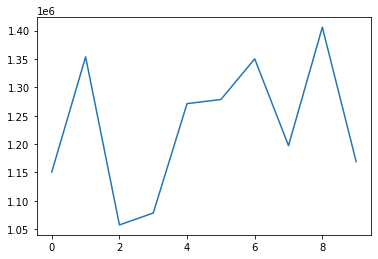

In [ ]:
population = initialize_population(2*population_size)                           #taking 2x population in beginning and will perform selection with start of first iterration itself
global_best_fitness = 0
global_best_params = {}
best_fitness_over_gen = []                                                      
                                                                                #Rest of the part is self explanatory
for i in range(no_of_its_GA):
  print("\n GA iteration : ",i+1,"\n")
  print("Population size before selection = ",len(population))
  
  population,best_params,best_fitness = selection(population,population_size)

  best_fitness_over_gen.append(best_fitness)

  if best_fitness > global_best_fitness:
    global_best_params = best_params

  for comb in itertools.combinations(np.arange(1,population_size),2):
    if random.random() < Pc:
      temp_c1,temp_c2 = crossover(population[comb[0]],population[comb[1]])
      population.append(temp_c1)
      population.append(temp_c1)
  
  for j in range(len(population)):
    if random.random() < Pm:
      temp_c1 = mutation(population[j]) 
      population.append(temp_c1)

plt.plot(best_fitness_over_gen)

In [ ]:
params = extract_params(global_best_params)

In [ ]:
params

{'LR': 0.0009920747321424943, 'Max_its': 496, 'NL1': 40, 'NL2': 72}

#**RESULTS USING BEST SET OF PARAMETRES OBTAINED FROM GA**

In [ ]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[params["NL1"],params["NL2"]], max_iter=params["Max_its"], learning_rate_init = params["LR"]) #,params["NL3"],params["NL4"]
model.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=[40, 72], learning_rate='constant',
             learning_rate_init=0.0009920747321424943, max_fun=15000,
             max_iter=496, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=None,
             shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
             verbose=False, warm_start=False)

In [ ]:
from sklearn.metrics import mean_squared_error

y_hat = model.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_hat,y_test))
print("RMSE over complete Test Set")
print(RMSE)

RMSE over complete Test Set
8.40159184512305


In [ ]:
RMSE_median = []
for d in test_drills:
  error = []
  for i in y[d].keys():
    if y[d][i] <= 5:
      error.append(model.predict([np.array(X[d].loc[i])])-y[d][i])
  
  RMSE_median.append(np.sqrt(np.mean(np.power(error,2))))

print("Median RMSE for last 5 holes of drills from test set")
print(statistics.median(RMSE_median))

Median RMSE for last 5 holes of drills from test set
5.6074830884984195


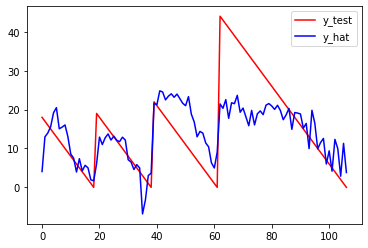

In [ ]:
#complete Test set RUL

plt.plot(y_test,color='r')
plt.plot(y_hat,color='b')
plt.legend(["y_test","y_hat"])
plt.show()

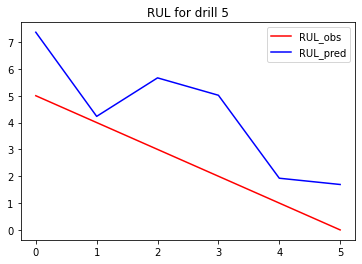

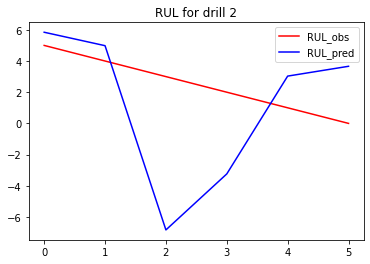

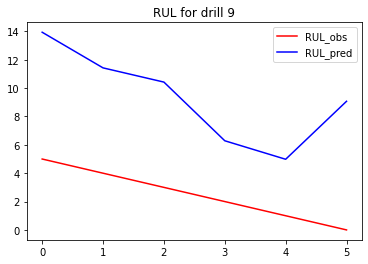

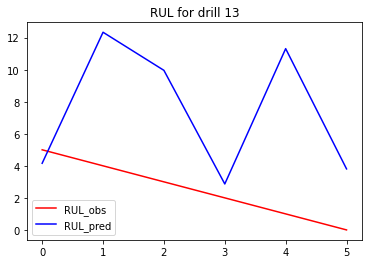

In [ ]:
#Plots for RUL of last 5 holes for drills in test set

for drill_no_test in test_drills:
  RUL_obs = []
  RUL_pred = []

  for i in y[drill_no_test].keys():
      if y[drill_no_test][i] <= 5:
        RUL_obs.append(y[drill_no_test][i])
        RUL_pred.append(model.predict([np.array(X[drill_no_test].loc[i])]))

  plt.title("RUL for drill %i"%drill_no_test)
  plt.plot(RUL_obs,color='r')
  plt.plot(RUL_pred,color='b')
  plt.legend(["RUL_obs","RUL_pred"])
  plt.show()

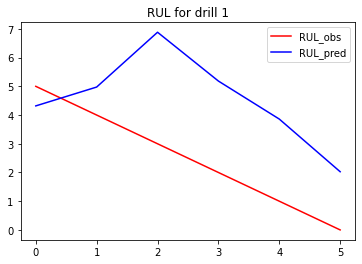

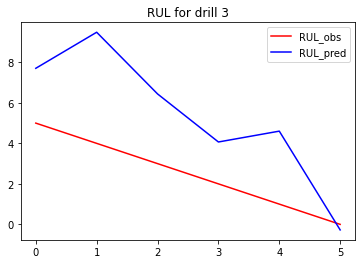

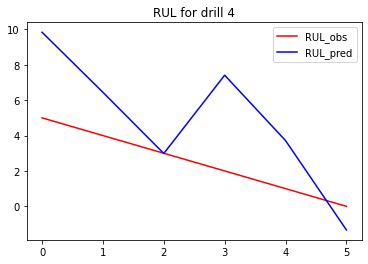

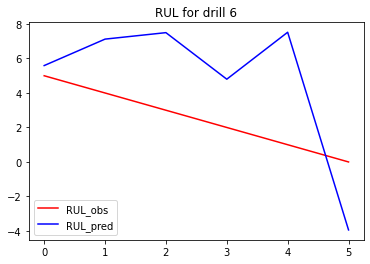

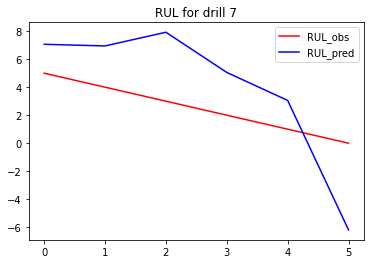

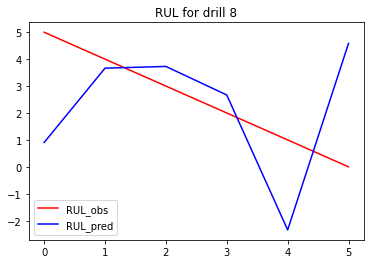

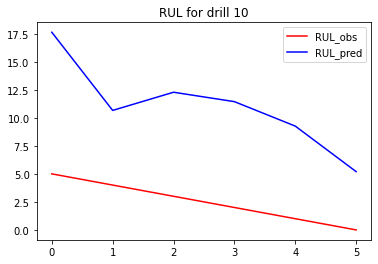

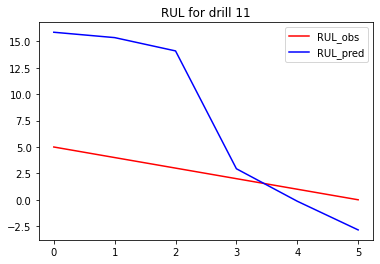

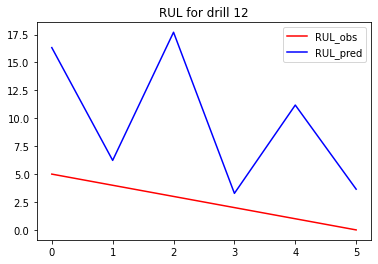

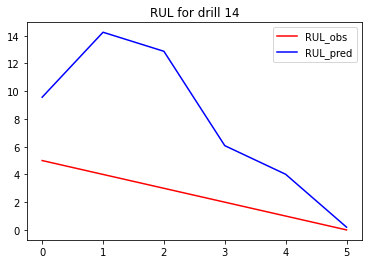

In [ ]:
#Plots for RUL of last 5 holes for drills in training set


for drill_no_test in train_drills:
  RUL_obs = []
  RUL_pred = []

  for i in y[drill_no_test].keys():
      if y[drill_no_test][i] <= 5:
        RUL_obs.append(y[drill_no_test][i])
        RUL_pred.append(model.predict([np.array(X[drill_no_test].loc[i])]))

  plt.title("RUL for drill %i"%drill_no_test)
  plt.plot(RUL_obs,color='r')
  plt.plot(RUL_pred,color='b')
  plt.legend(["RUL_obs","RUL_pred"])
  plt.show()

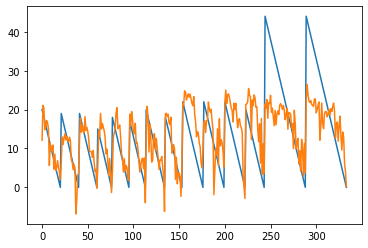

In [ ]:
#Plot for RUL complete dataset

X_full = D.drop(["RUL","drill"],axis=1)
y_full = D["RUL"]

plt.plot(y_full)
plt.plot(model.predict(X_full))
plt.show()